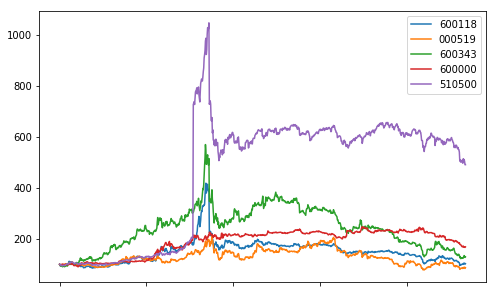

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 28 01:49:22 2020

@author: GT72VR
"""

import numpy as np
import pandas as pd
import datetime
import tushare as ts
import matplotlib.pyplot as plt

# 军工类股票 中国卫星 （600118）、中兵红箭 （000519） 、航天动力 （600343） ，
# 以及浦发银行（600000 ）和 中证500指数基金 500ETF （510500 ）
symbols = ['600118', '000519', '600343', '600000', '510500']

indexes = pd.date_range('2014-01-01', '2018-07-06')
# 为了保持和从toshare获取的时间序列类型一致，这里把时间类型转为字符串
indexes = indexes.map(lambda x: datetime.datetime.strftime(x, '%Y-%m-%d'))

data = pd.DataFrame(index=indexes)
for sym in symbols:
    k_d = ts.get_k_data(sym, '2014-01-01', ktype='D')
    # 如果上面的时间序列不转成字符串，这里就要转成时间序列，以保持index类型一致
    # k_d['date'] = k_d['date'].astype('datetime64[ns]')
    k_d.set_index('date', inplace=True)
    data[sym] = k_d['close']
data = data.dropna()

#(data / data.ix[0] * 100).plot(figsize=(8, 5))
(data / data.iloc[0] * 100).plot(figsize=(8, 5))

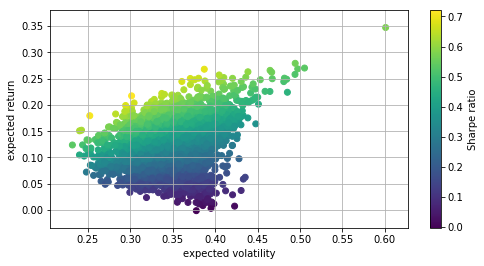

In [2]:
# 均值-方差指的是不同证券（对数）收益的均值和方差, 可以这样计算:
rets = np.log(data / data.shift(1))
# 在这些时间序列数据中， 可以看到年化收益表现的显著差异。
# 我们使用 252 个交易日，从每日收益得出年化收益：
rets.mean() * 252
# 600118    0.006067
# 000519   -0.038631
# 600343    0.068651
# 600000    0.140085
# 510500    0.428569
# dtype: float64

# 投资资产的协方差矩阵是整个投资组合选择过程的核心部分
rets.cov()*252
#           600118    000519    600343    600000    510500
# 600118  0.237557  0.107797  0.177612  0.017609  0.102007
# 000519  0.107797  0.209140  0.123730  0.012978  0.062838
# 600343  0.177612  0.123730  0.238805  0.013859  0.095337
# 600000  0.017609  0.012978  0.013859  0.064694  0.022098
# 510500  0.102007  0.062838  0.095337  0.022098  0.510833


######### 11.2.2 基本理论

# 生成 5 个 0 到 1之间的随机数， 
# 然后对这些数值进行规范化，使所有值的总和为1
noa = 5
weights = np.random.random(noa)
weights /= np.sum(weights)
weights
# array([ 0.21076189,  0.23917961,  0.1825734 ,  0.03619006,  0.33129504])

# 预期投资组合方差
np.dot(weights.T, np.dot(rets.cov() * 252, weights))
# 0.14184053722017648

# 预期投资组合标准差
#（预期）投资组合标准差（波动率）只需要计算一次平方根即可得到
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
# 0.37661722905381861

prets = []
pvols = []
for p in range(2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))))

prets = np.array(prets)
pvols = np.array(pvols)

plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

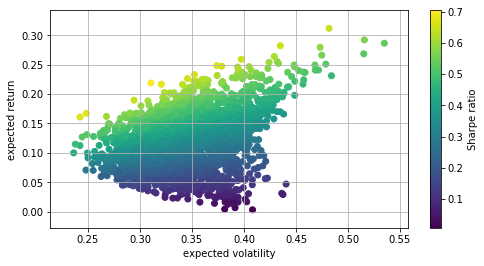

In [3]:
#######11.2.3 投资组合优化

# 生成 5 个 0 到 1之间的随机数，
# 然后对这些数值进行规范化，使所有值的总和为1
noa = 5
weights = np.random.random(noa)
weights /= np.sum(weights)
weights
# array([ 0.21076189,  0.23917961,  0.1825734 ,  0.03619006,  0.33129504])

# 预期投资组合方差
np.dot(weights.T, np.dot(rets.cov() * 252, weights))
# 0.14184053722017648

# 预期投资组合标准差
# （预期）投资组合标准差（波动率）只需要计算一次平方根即可得到
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
# 0.37661722905381861

prets = []
pvols = []
for p in range(2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))))

prets = np.array(prets)
pvols = np.array(pvols)

plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

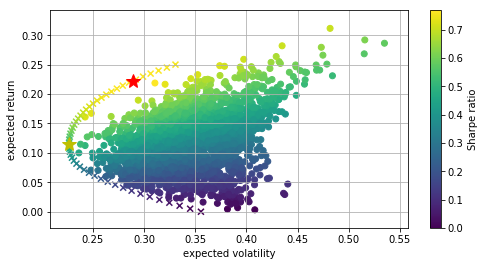

In [5]:
# 11.2.3 投资组合优化
# 首先建立一个方便的函数，为输入的权重向量 / 数组给出重要的投资组合统计数字：
def statistics(weights):
    """
    Return portfolio statistics
    :param weights: weights for different securities in portfolio
    :return:
    pret:float
    expected portfolio return
    pvol:float
    expected portfolio volatility
    pret/pvol:float
    Sharpe ratio for rf=0
    """
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

# 最优化投资组合的推导是一个约束最优化问题
import scipy.optimize as sco


# 最小化函数minimize很通用，考虑了参数的（不）等式约束和参数的范围。
# 我们从夏普指数的最大化开始。 正式地说，最小化夏普指数的负值：
def min_func_sharpe(weights):
    return -statistics(weights)[2]


# 约束是所有参数（权重）的总和为1。 这可以用minimize函数的约定表达如下
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# 我们还将参数值（权重）限制在0和l之间。 这些值以多个元组组成的一个元组形式提供给最小化函数：
bnds = tuple((0, 1) for x in range(noa))

# 优化函数调用中忽略的唯一输入是起始参数列表（对权重的初始猜测）。我们简单地使用平均分布：
noa * [1. / noa, ]
# [0.2, 0.2, 0.2, 0.2, 0.2]

#%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa, ], method='SLSQP', bounds=bnds, constraints=cons)
# Wall time: 1.2 s

opts
# fun: -0.7689821435140733
# jac: array([3.62539694e-01, 3.84121098e-01, 1.03567891e-01,
#             -1.06185675e-04, 2.67580152e-04])
# message: 'Optimization terminated successfully.'
# nfev: 59
# nit: 8
# njev: 8
# status: 0
# success: True
# x: array([2.69140628e-17, 5.93820112e-17, 0.00000000e+00,
#           7.15876612e-01, 2.84123388e-01])

opts['x'].round(3)
# array([ 0.   ,  0.   ,  0.   ,  0.716,  0.284])

# 最优化工作得出 一个投资组合，仅由5种资产中的2种组成

# 使用优化中得到的投资组合权重， 得出如下统计数字
statistics(opts['x'].round(3))
# array([ 0.22201418,  0.28871174,  0.76898216])
# 预期收益率约为22.2%. 预期被动率约为28.9%， 得到的最优夏普指数为0.77

# 接下来， 我们最小化投资组合的方差。
# 这与被动率的最小化相同，我们定义一个函数对方差进行最小化：
def min_func_variance(weights):
    return statistics(weights)[1]**2

optv = sco.minimize(min_func_variance, noa * [1. / noa, ], method='SLSQP', bounds=bnds, constraints=cons)
optv
# fun: 0.05137907199877911
# jac: array([0.10326265, 0.10273764, 0.10269385, 0.10276436, 0.102121])
# message: 'Optimization terminated successfully.'
# nfev: 71
# nit: 10
# njev: 10
# status: 0
# success: True
# x: array([0.04526382, 0.1335909, 0.05702634, 0.73177776, 0.03234118])

optv['x'].round(3)
# array([ 0.045,  0.134,  0.057,  0.732,  0.032])
# 投资组合中加入了全部资产。 这种组合可以得到绝对值最小方差投资组合
# 得到的预期收益率、波动率和夏普指数如下：
statistics(optv['x']).round(3)
# array([ 0.115,  0.227,  0.509])

############  11.2.4 有效边界

def min_func_port(weights):
    return statistics(weights)[1]


# 在不同目标收益率水平（ trets ）中循环时。 最小化的一个条件会变化。
# 这就是每次循环中更新条件字典对象的原因：

trets = np.linspace(0.0, 0.25, 50)
tvols = []
bnds = tuple((0, 1) for x in weights)
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa, ], method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

plt.figure(figsize=(8,4))
# random portfolio composition
plt.scatter(pvols,prets,c=prets/pvols,marker='o')
# efficient frontier
plt.scatter(tvols,trets,c=trets/tvols,marker='x')
# portfolio with highest Sharpe ratio
plt.plot(statistics(opts['x'])[1],statistics(opts['x'])[0],'r*',markersize=15.0)
# minimum variance portfolio
plt.plot(statistics(optv['x'])[1],statistics(optv['x'])[0],'y*',markersize=15.0)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

array([0.   , 0.   , 0.   , 0.703, 0.297])

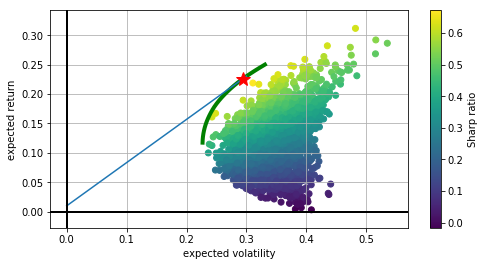

In [6]:
#####  11.2.5 资本市场线

import scipy.interpolate as sci

ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

tck = sci.splrep(evols, erets)

# 通过这条数值化路径，最终可以为有效边界定义一个连续可微函数
# 和对应的一阶导数函数df(x):

def f(x):
    """
    Efficient frontier function (splines approximation)
    :param x:
    :return:
    """
    return sci.splev(x, tck, der=0)


def df(x):
    """
    First derivative of efficient frontier function.
    :param x:
    :return:
    """
    return sci.splev(x, tck, der=1)


# 定义一个函数，返回给定参数集p=(a,b,x)
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1]-df(p[2])
    return eq1,eq2,eq3

# 数值优化得到如下的值
opt=sco.fsolve(equations,[0.01,0.5,0.15])
opt
# array([ 0.01      ,  0.73464122,  0.29383737])


plt.figure(figsize=(8, 4))
# random portfolio composition
plt.scatter(pvols, prets, c=(prets - 0.01) / pvols, marker="o")
# efficient frontier
plt.plot(evols, erets, 'g', lw=4.0)
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=1.5)
# capital market line
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='-', lw=2.0)
plt.axvline(0, color='k', ls='-', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharp ratio')


cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - f(opt[2])},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
res = sco.minimize(min_func_port, noa * [1. / noa, ],
                   method='SLSQP', bounds=bnds, constraints=cons)
res['x'].round(3)
# array([ 0.   ,  0.   ,  0.   ,  0.703,  0.297])

